In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train)*5)

In [3]:
def f(x):
    return 2* torch.sin(x) + x**0.8

In [5]:
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1) # 0 到 5，间距 0.1
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['truth', 'pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

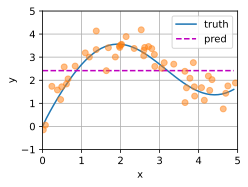

In [7]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])


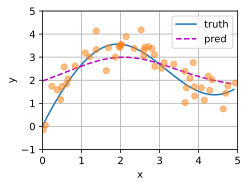

In [8]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
print(X_repeat)
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

torch.Size([50, 50])
tensor([[8.1063e-02, 8.0862e-02, 7.8801e-02,  ..., 1.3220e-06, 1.0234e-06,
         3.9780e-07],
        [7.5239e-02, 7.5460e-02, 7.4766e-02,  ..., 1.9587e-06, 1.5245e-06,
         6.0425e-07],
        [6.9537e-02, 7.0121e-02, 7.0637e-02,  ..., 2.8897e-06, 2.2614e-06,
         9.1396e-07],
        ...,
        [1.1405e-06, 1.4682e-06, 3.1181e-06,  ..., 6.5453e-02, 6.5372e-02,
         6.3523e-02],
        [7.6268e-07, 9.8722e-07, 2.1316e-06,  ..., 6.9872e-02, 7.0166e-02,
         6.9523e-02],
        [5.0807e-07, 6.6123e-07, 1.4516e-06,  ..., 7.4301e-02, 7.5019e-02,
         7.5795e-02]])


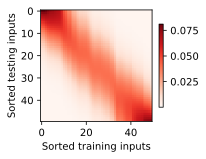

In [9]:
print(attention_weights.shape)
print(attention_weights)
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [10]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [15]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1).shape)
print(values.unsqueeze(-1).shape)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

torch.Size([2, 1, 10])
torch.Size([2, 10, 1])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [39]:
class NWkernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    
    def forward(self, queries, keys, values):
        # queries 和 attention_weights 的形状为 (num_query, num_k-v)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        
        # values 的形状为 (num_value, num_k-v)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)
        

In [40]:
print(x_train)
print(x_train.shape)

tensor([0.0186, 0.0729, 0.2386, 0.3812, 0.4625, 0.4916, 0.5545, 0.6122, 0.6539,
        0.8355, 1.0947, 1.1989, 1.3751, 1.3763, 1.6346, 1.6867, 1.8650, 1.9698,
        1.9789, 2.0083, 2.0264, 2.1413, 2.3476, 2.5287, 2.5936, 2.5973, 2.6180,
        2.7161, 2.7982, 2.8664, 2.8768, 3.0537, 3.1181, 3.3626, 3.6492, 3.6521,
        3.6881, 3.7768, 3.8642, 3.8899, 3.8987, 4.0744, 4.1460, 4.2498, 4.2847,
        4.3427, 4.6316, 4.6955, 4.7497, 4.9447])
torch.Size([50])


In [41]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
print(X_tile)
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
print(keys)
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

tensor([[0.0186, 0.0729, 0.2386,  ..., 4.6955, 4.7497, 4.9447],
        [0.0186, 0.0729, 0.2386,  ..., 4.6955, 4.7497, 4.9447],
        [0.0186, 0.0729, 0.2386,  ..., 4.6955, 4.7497, 4.9447],
        ...,
        [0.0186, 0.0729, 0.2386,  ..., 4.6955, 4.7497, 4.9447],
        [0.0186, 0.0729, 0.2386,  ..., 4.6955, 4.7497, 4.9447],
        [0.0186, 0.0729, 0.2386,  ..., 4.6955, 4.7497, 4.9447]])
tensor([[0.0729, 0.2386, 0.3812,  ..., 4.6955, 4.7497, 4.9447],
        [0.0186, 0.2386, 0.3812,  ..., 4.6955, 4.7497, 4.9447],
        [0.0186, 0.0729, 0.3812,  ..., 4.6955, 4.7497, 4.9447],
        ...,
        [0.0186, 0.0729, 0.2386,  ..., 4.6316, 4.7497, 4.9447],
        [0.0186, 0.0729, 0.2386,  ..., 4.6316, 4.6955, 4.9447],
        [0.0186, 0.0729, 0.2386,  ..., 4.6316, 4.6955, 4.7497]])


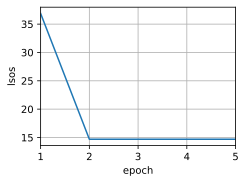

In [42]:
net = NWkernelRegression()
loss = nn.MSELoss(reduction='none') # 维度不缩减
trainer = torch.optim.SGD(net.parameters(), lr = 0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='lsos', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

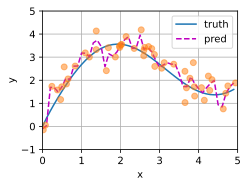

In [43]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

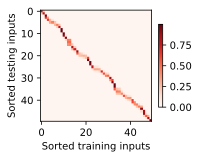

In [44]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')